# FAQ

Notebook where we answer some questions about the model that may arise.

In [2]:
import torch

### Scaling log preferences

When computing the risk (observations) term in the EFE, $D_{KL}[q(\bar o_j|u)||p^*(o_j)]$,
we use the algebraic form $\mathbf{\bar o}_j (\log \mathbf{\bar o}_j - \log \boldsymbol{\mathsf{C}}^j)$
(logs are always shifted by EPSILON to avoid numerical issues).
Noting that, 
$$
\log \boldsymbol{\mathsf{C}}^j = \log p^*(o_j) = \mathbb{E}_{q(\bar o_i=u_i, \bar o_k)}[\log p^*(o_i=u_i, o_j, o_k)]
$$

One might be concerned that we do not normalise or otherwise scale $\log p^*(o_j)$ to be in the same "range" as $\log q(\bar o_j|u)$.

The next cell shows that this is not necessary, as the relative KL divergence between the actions is invariant to scaling of the target distribution.
The risk for each action is different if we scale the target distribution, but the **relative risk between actions is the same whether we rescale or not**.

In [7]:
import torch

num_actions = 2
EPSILON = 1e-9
log_C_modality = torch.tensor([-2.0965, 5.6])  # Assume at the current timestep the log C_modality is this

def print_metrics(log_C_modality):
    risk = []
    for u_i in [0, 1]:
        o_pred = torch.tensor([1.0 if i == u_i else 0.0 for i in range(num_actions)])
        log_o_pred = torch.log(o_pred + EPSILON)
        print('q(o|u)', o_pred.tolist(), sep='\t\t')
        print('log q(o|u)', log_o_pred.tolist(), sep='\t')
        print('log p*(o)', log_C_modality.tolist(), sep='\t')
        risk.append((o_pred @ (log_o_pred - log_C_modality)).item())
        print('Risk', risk[u_i], sep='\t\t')
        
        # Compute exp(log C_modality) and log p(^o)
        exp_log_C_modality = torch.exp(log_C_modality)
        print('exp(log p*(o)) = p(^o)', exp_log_C_modality.tolist(), sep='\t')
        
        log_p_hat_o = torch.log(exp_log_C_modality + EPSILON)
        print('log p(^o)', log_p_hat_o.tolist(), sep='\t')
        
        print()
        
    print('Delta risk', risk[1] - risk[0], sep='\t')


print('FIRST, AS IS ------------------------')
print_metrics(log_C_modality)

print('\nSECOND, NORMALISED ------------------------')
C_mod = torch.softmax(log_C_modality, dim=0)
log_C_modality = torch.log(C_mod + EPSILON)  # cf. LogSumExp
print_metrics(log_C_modality)


# THIRD VERSION: Exponential of log_C, then softmax, and then log if necessary
print('\nTHIRD VERSION, Exponentiate and Softmax ------------------------')
C_mod = torch.exp(log_C_modality)  # Step 1: Exponentiate to get C from log_C
print("C_mod (after exp):", C_mod.tolist())

C_mod = torch.softmax(C_mod, dim=0)  # Step 2: Apply softmax to C
print("C_mod (after softmax):", C_mod.tolist())

log_C_modality = torch.log(C_mod + EPSILON)  # Step 3: Take the log of softmax'ed C
print("log_C_modality (after log):", log_C_modality.tolist())

print_metrics(log_C_modality)

FIRST, AS IS ------------------------
q(o|u)		[1.0, 0.0]
log q(o|u)	[0.0, -20.7232666015625]
log p*(o)	[-2.0964999198913574, 5.599999904632568]
Risk		2.0964999198913574
exp(log p*(o)) = p(^o)	[0.12288578599691391, 270.4263916015625]
log p(^o)	[-2.0964999198913574, 5.599999904632568]

q(o|u)		[0.0, 1.0]
log q(o|u)	[-20.7232666015625, 0.0]
log p*(o)	[-2.0964999198913574, 5.599999904632568]
Risk		-5.599999904632568
exp(log p*(o)) = p(^o)	[0.12288578599691391, 270.4263916015625]
log p(^o)	[-2.0964999198913574, 5.599999904632568]

Delta risk	-7.696499824523926

SECOND, NORMALISED ------------------------
q(o|u)		[1.0, 0.0]
log q(o|u)	[0.0, -20.7232666015625]
log p*(o)	[-7.696951866149902, -0.00045435020001605153]
Risk		7.696951866149902
exp(log p*(o)) = p(^o)	[0.0004542095703072846, 0.9995457530021667]
log p(^o)	[-7.696949481964111, -0.00045435020001605153]

q(o|u)		[0.0, 1.0]
log q(o|u)	[-20.7232666015625, 0.0]
log p*(o)	[-7.696951866149902, -0.00045435020001605153]
Risk		0.000454350200016

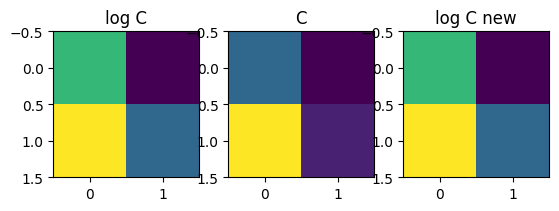

(tensor([[3., 1.],
         [4., 2.]]),
 tensor([[0.2369, 0.0321],
         [0.6439, 0.0871]]),
 tensor([[-1.4402, -3.4402],
         [-0.4402, -2.4402]]))

In [13]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from games import *

log_C = prisoners_dilemma_2player

#Format log_C into a legit probability distribution
flattened_C = torch.softmax(log_C.flatten(), dim=0)
C = flattened_C.view_as(log_C)
log_C_new = torch.log(C)
assert torch.isclose(
        torch.exp(log_C_new).sum(), 
        torch.tensor(1.0), 
        atol=1e-6), (
    "The sum of exponentiated values of log C is not 1."
)

# Plot
fig, axs = plt.subplots(1, 3)
axs[0].imshow(log_C)
axs[0].set_title('log C')
axs[1].imshow(C)
axs[1].set_title('C')
axs[2].imshow(log_C_new)
axs[2].set_title('log C new')
plt.show()

log_C, C, log_C_new

## Novelty

In [29]:
import torch

## Scaffold
num_actions = 2
num_agents = 2
EPSILON = torch.finfo().eps
A_params = torch.stack([torch.eye(num_actions) for _ in range(num_agents)]) + EPSILON  # Identity observation model prior

# A_params += 0.1
A_params = torch.softmax(4*A_params, dim=2)
print(A_params)
A = A_params / A_params.sum(dim=1, keepdim=True)

q_s_u = torch.tensor([
    [0.43, 0.57],
    [0.57, 0.43]
])

#############
novelty = 0
# Da Costa et al. (2020; Eq. D.17)
W = 0.5 * (1/A_params - 1/A_params.sum(dim=1, keepdim=True))
for factor_idx in range(num_agents):
    s_pred = q_s_u[factor_idx]
    novelty += torch.dot(
        A[factor_idx] @ s_pred, 
        W[factor_idx] @ s_pred)
novelty

tensor([[[0.9820, 0.0180],
         [0.0180, 0.9820]],

        [[0.9820, 0.0180],
         [0.0180, 0.9820]]])


tensor(26.7926)

## BMR

In [50]:
import torch.nn.functional as F

num_agents = 2
num_actions = 2

# Scaffolding
B_posterior_params = torch.tensor([
    [[  # Factor i -------------
        [1.01, 1.03],    # u = 0
        [1.03, 1.35]],
    [
        [1.01, 1.03],    # u = 1
        [1.03, 1.35]]],

    [[  # Factor j -------------
        [1.38, 1.02],    # u = 0
        [1.02, 1.00]],
    [
        [1.38, 1.02],    # u = 1
        [1.02, 1.00]]]
])

B_params = torch.tensor([[[[1.01, 1.03],
          [1.03, 1.31]],

         [[1.01, 1.03],
          [1.03, 1.31]]],


        [[[1.34, 1.02],
          [1.02, 1.00]],

         [[1.34, 1.02],
          [1.02, 1.00]]]])

print(B_params)
B_reduced = F.softmax(0.5*B_params.view(num_agents, num_actions, -1), dim=-1).view_as(B_params)
print(B_reduced)

tensor([[[[1.0100, 1.0300],
          [1.0300, 1.3100]],

         [[1.0100, 1.0300],
          [1.0300, 1.3100]]],


        [[[1.3400, 1.0200],
          [1.0200, 1.0000]],

         [[1.3400, 1.0200],
          [1.0200, 1.0000]]]])
tensor([[[[0.2391, 0.2415],
          [0.2415, 0.2778]],

         [[0.2391, 0.2415],
          [0.2415, 0.2778]]],


        [[[0.2819, 0.2402],
          [0.2402, 0.2378]],

         [[0.2819, 0.2402],
          [0.2402, 0.2378]]]])


In [63]:
B_prior = B_params / B_params.sum(dim=2, keepdim=True)
B_posterior = B_posterior_params / B_posterior_params.sum(dim=2, keepdim=True)

# Expected value (under B_posterior) of the ratio of the reduced to the prior
torch.log(
    torch.einsum(
        'funk,funk->fu',
        B_posterior,
        B_reduced / B_prior
        # B_prior / B_reduced
    )
)

tensor([[-0.0004, -0.0004],
        [-0.0004, -0.0004]])

In [59]:
(B_reduced[0, 0].flatten() / B_prior[0, 0].flatten()) @ B_posterior[0, 0].flatten()

tensor(0.9996)